# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [3]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x = r_0, y = 0 * m, vx = 0 * m/s, vy = 0 * m/s)

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,0.0 meter / second


In [17]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e9 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,1000000000.0 second


In [19]:
#%psource ModSimVector

In [20]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    
    x, y, vx, vy = state
    
    position = Vector(x,y)
    force = system.G * system.m1 * system.m2 / position.mag2
    fx = -1 * force * math.cos(position.angle)
    fy = -1 * force * math.sin(position.angle)
    force_vector = Vector(fx, fy)
    return force_vector


In [21]:
universal_gravitation(init, system)

<Quantity([-3.6686486e+22 -0.0000000e+00], 'newton')>

In [22]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of x, y, vx, and vy
    """    
    x, y, vx, vy = state
    
    #print('Velocity: ', vx, '   Position: ', x)
    
    dxdt = vx
    dydt = vy
    
    dvdt = universal_gravitation(state, system) / system.m2
    dvxdt = dvdt.x
    dvydt = dvdt.y
    
    return dxdt, dydt, dvxdt, dvydt

In [23]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [24]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    x, y, dx, dy = state
    position = Vector(x, y)
    return position.mag - system.r_final

In [25]:
# Always test the event function!

event_func(init, 0, system)

<Quantity(146298121000.0, 'meter')>

In [26]:
system.init

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,0.0 meter / second


In [27]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func, max_step=10000 * s)
details

,values
sol,None
t_events,[[5432622.136842448]]
nfev,3332
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [28]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(5432622.136842448, 'second')>

In [29]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(62.87757102826907, 'day')>

In [30]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

NameError: name 't_0' is not defined

In [31]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [39]:
%psource ModSimDataFrame

In [ ]:
# Scaling the distance to million km

def convert_to_r(results):

    t = 0
    r = TimeSeries() 
    for x in results.x:
        for y in results.y:
            r[t] = math.sqrt(x ** 2 + y ** 2)
            print(r, t)
            t += 1
    
    return r

newres = convert_to_r(results)

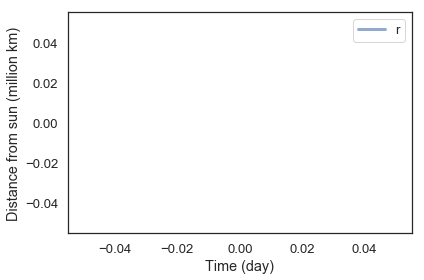

In [211]:
# And plotting

plot(r, label='r')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')